#### **Librerías**

In [1]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import IPython
import gc
import torch.nn.functional as F
import torchaudio.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import torch.optim as optim
import torchaudio.transforms as T

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from typing import Dict
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchaudio.sox_effects import apply_effects_tensor
from typing import Optional

%matplotlib inline

#### **Funciones**

In [2]:
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

#### **Clases**

In [42]:
class MusicDataset(Dataset):
    def __init__(self, root = './genres_5sec/'):
        super().__init__()
        self.root = root
        self.files =[]
        classes = self.get_classes(self.root)
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        return audio, class_idx

    def get_classes(self, root):
        list_files = os.listdir(root)
        classes = []
        for file in list_files:
            name = '{}/{}'.format(root, file)
            if os.path.isdir(name):
                classes.append(file)
        return classes

# [(W−K+2P)/S]+1, where W is the input size, K is the kernel size, P is the padding, and S is the stride.
class CELAutoenconder(nn.Module):
    def __init__(self):
        super(CELAutoenconder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 110250 (formula: [(110250-9+2*4)/1]+1 = [(110250-9+8)/1]+1 = [110250/1]+1 = 110250+1 = 110251) -> 16x110250
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 110250 -> Output size = 110249 (formula: [(110250-2)/2]+1 = [(110248)/2]+1 = 110248/2+1 = 55124+1 = 55125) -> 16x55125
            
            nn.Conv1d(16, 32, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 55125 -> 32x55125
            nn.ReLU(),
            
            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 55125 -> 64x55125
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 55125 -> Output size = 27562 -> 64x27562
            
            nn.Conv1d(64, 128, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 128x27562
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 256x27562
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 27562 -> Output size = 13781 -> 256x13781

            nn.Conv1d(256, 512, kernel_size=9, stride=1, padding=4), # Input size = 13781 -> Output size = 13781 -> 512x13781
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 13781 -> Output size = 6890 -> 512x6890
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 6890 -> Output size = 13781 -> 256x13781
            nn.ReLU(),
            nn.Upsample(size=27562),  # Tamaño específico en lugar de scale_factor
            
            nn.ConvTranspose1d(256, 128, kernel_size=9, stride=1, padding=4), # Input size = 13781 -> Output size = 27562 -> 128x27562
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 55125 -> 64x27562
            nn.ReLU(),
            nn.Upsample(size=55125),  # Tamaño específico
            
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 110250 -> 32x55125
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 110250 -> 16x55125
            nn.ReLU(),
            nn.Upsample(size=110250),  # Tamaño específico para match exacto
            
            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 220500 -> 1x110250
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        if decoded.size(2) != x.size(2):
            decoded = F.interpolate(decoded, size=x.size(2), mode='linear')
        return decoded

In [43]:
samplerate = 22050

random_seed = 43992294

torch.manual_seed(random_seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else
                    'mps' if torch.backends.mps.is_available() else
                    'cpu')

print(f"Dispositivo usado: {device}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"MPS disponible: {torch.backends.mps.is_available()}")

Dispositivo usado: mps
CUDA disponible: False
MPS disponible: True


In [44]:
dataset = MusicDataset()

#### **Visualización**

In [45]:
waveform, label = dataset[1]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 3 


shape of spectogram torch.Size([1, 201, 552])


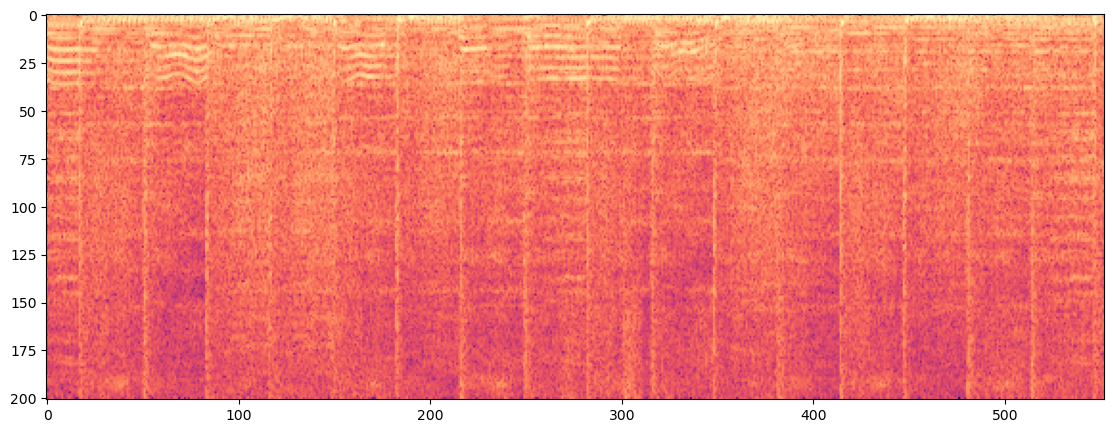

In [46]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[-0.0020,  0.0655,  0.1253,  ..., -0.0604, -0.0465, -0.0552]])



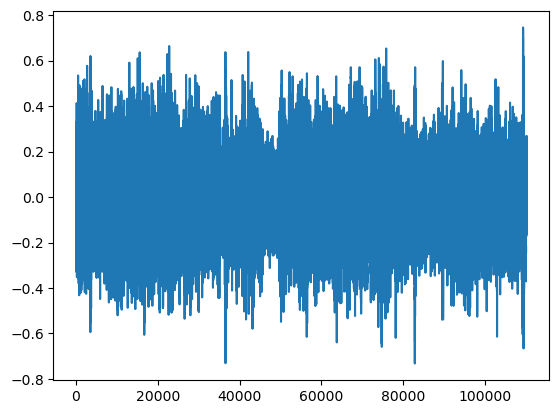

In [47]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

In [48]:
IPython.display.Audio(waveform,rate=samplerate)

#### **Experimentos**


In [49]:
batch_size = 20
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

if torch.cuda.is_available():
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
    test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)
else:
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size*2)
    test_dl = DataLoader(test_ds,1)

In [50]:
# Inicialización del modelo
autoencoder = CELAutoenconder().to(device)

# Parámetros del modelo
parameters = [p for p in autoencoder.parameters() if p.requires_grad]

# Optimizador
optimizer = optim.Adam(parameters, lr=0.001)

# Obtener un lote de datos de entrenamiento
wav, label = next(iter(train_dl))
print("Forma de los datos antes de moverlos al dispositivo:", wav.shape)

# Mover los datos al dispositivo seleccionado
wav = wav.to(device)

# Imprimir la forma de los datos
print("Forma de los datos después de moverlos al dispositivo:", wav.shape)

Forma de los datos antes de moverlos al dispositivo: torch.Size([20, 1, 110250])
Forma de los datos después de moverlos al dispositivo: torch.Size([20, 1, 110250])


In [51]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
valid_losses = []
num_epochs = 5

torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram

for epoch in range(num_epochs):
    losses = []

    # Train
    autoencoder.train()
    for wav, _ in train_dl:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)

        # Forward
        out = autoencoder(wav)

        # Slice the last 23 points
        loss = loss_function(out, wav)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav 
        del loss 
        del out 
        torch.cuda.empty_cache()  
        gc.collect() 

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

RuntimeError: MPS backend out of memory (MPS allocated: 8.26 GB, other allocations: 472.49 MB, max allowed: 9.07 GB). Tried to allocate 538.32 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
wav, _ = next(iter(train_dl))

IPython.display.Audio(wav[1],rate=samplerate)

In [ ]:
prediction = autoencoder(wav.to(device)).detach()

IPython.display.Audio(prediction[1].cpu(),rate=samplerate)